## Generative Adversarial Networks (GAN)

Introduced by Ian Goodfelllow in 2014: two deep networks, called **Generator** and **Discriminator**, that compete and cooperate with each other.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Input, BatchNormalization
from keras.optimizers import Adam
from keras.datasets.mnist import load_data
from tqdm import tqdm

plt.style.use("dark_background")

In [2]:
# Load dataset

(xtrain, ytrain), (xtest, ytest) = load_data()
x = (xtrain.astype("float32") - 127.5)/127.5
x.shape, x.min(), x.max()

((60000, 28, 28), -1.0, 1.0)

In [3]:
# Generator

def build_generator(latent_dim=100):
    generator = Sequential()
    
    generator.add(Dense(units=7*7*128, input_shape=(latent_dim, )))
    generator.add(Reshape((7, 7, 128)))
    generator.add(LeakyReLU(alpha=0.3))
    generator.add(BatchNormalization())

    # (7, 7, 128) --> (14, 14, 64)
    generator.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())

    # (14, 14, 64) --> (28, 28, 1)
    generator.add(Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="tanh"))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    generator.compile(loss="binary_crossentropy", optimizer=opt)

    return generator

In [4]:
generator = build_generator(latent_dim=100)
generator.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                         

2022-06-08 13:10:57.107877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 13:10:57.107981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 [==============================] - 0s 87ms/step


2022-06-08 13:10:57.531206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-08 13:10:57.583763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


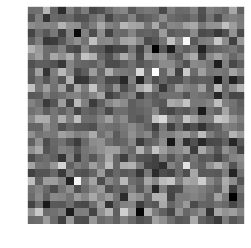

In [5]:
noise = np.random.normal(0, 1, size=(1, 100))
test_image = generator.predict(noise)

plt.imshow(test_image.reshape((28, 28)), cmap="gray")
plt.show()

In [6]:
# Discriminator

def build_discriminator():
    discriminator = Sequential()

    # input --> (28, 28, 1) --> (14, 14, 64)
    discriminator.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", input_shape=(28, 28, 1)))
    discriminator.add(LeakyReLU(alpha=0.2))

    # (14, 14, 64) --> (7, 7, 128)
    discriminator.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))

    # (7, 7, 128) --> 6272
    discriminator.add(Flatten())
    discriminator.add(Dense(units=100))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Dense(units=1, activation="sigmoid"))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss="binary_crossentropy", optimizer=opt)

    return discriminator
    

In [7]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               627300    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)              

In [8]:
decision = discriminator(test_image)
print(decision)

tf.Tensor([[0.5000458]], shape=(1, 1), dtype=float32)


In [9]:
# Define GAN

def build_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(100, ))
    gen = generator(gan_input)
    gan_output = discriminator(gen)
    
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer="adam")

    return gan

In [10]:
gan = build_gan(generator, discriminator)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         708609    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 701897    
                                                                 
Total params: 1,410,506
Trainable params: 708,225
Non-trainable params: 702,281
_________________________________________________________________


In [11]:
# Reshape dataset

x_train_reshaped = x.reshape(-1, 28, 28, 1)
x_train_reshaped.shape

(60000, 28, 28, 1)

In [12]:
# Plot images

def plot_images(epoch, generator, n_examples=25, dim=(5, 5)):
    noise = np.random.normal(0, 1, size=(n_examples, 100))
    generated = generator.predict(noise)
    generated = generated.reshape(n_examples, 28, 28)
    
    plt.figure(figsize=dim)
    for i in range(generated.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated[i], interpolation="nearest")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"generated_image_{epoch + 1}")
    plt.close()

In [14]:
# Train

def train(epochs, generator, discriminator, gan, dataset, latent_dim, batch_size):

    n_batch = int(dataset.shape[0]/batch_size)
    half_batch = int(batch_size/2)

    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        d_temp_loss = 0.0
        g_temp_loss = 0.0

        for step in range(n_batch):
            
            # --> STEP 1: TRAIN DISCRIMINATOR
            discriminator.trainable = True

            # get real images
            indx = np.random.randint(0, dataset.shape[0], half_batch)
            x_real = dataset[indx]

            # get fake images
            noise = np.random.normal(0, 1, size=(half_batch, latent_dim))
            x_fake = generator.predict(noise, verbose=0)

            # labels: 1 for real, 0 for fake
            y_real = np.ones((half_batch, 1)) * 0.9
            y_fake = np.zeros((half_batch, 1))

            # train discriminator
            d_loss_real = discriminator.train_on_batch(x_real, y_real)
            d_loss_fake = discriminator.train_on_batch(x_fake, y_fake)

            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_temp_loss += d_loss
            d_temp_loss /= n_batch

            # --> STEP 2: TRAIN GENERATOR
            discriminator.trainable = False

            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            y_noise = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(noise, y_noise)

            g_temp_loss += g_loss
            g_temp_loss /= n_batch

            # Print out
            print(f"Epoch: [{epoch + 1}]\tDiscriminator loss: [{d_temp_loss}]\tGenerator Loss: [{g_temp_loss}]", end="\r")

            d_losses.append(d_temp_loss)
            g_losses.append(g_temp_loss)

        if (epoch + 1)%10 == 0:
            plot_images(epoch=epoch, generator=generator)
    
    generator.save(f"mnist_gan_{epochs}_epochs.h5")

    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    ax[0].plot(d_losses)
    ax[0].set_title("Discriminator Loss")

    ax[1].plot(g_losses)
    ax[1].set_title("Generator Loss")
    
    plt.show()

2022-06-08 13:13:09.242678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 13:13:09.586060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step9724]	Generator Loss: [0.005682258291012101


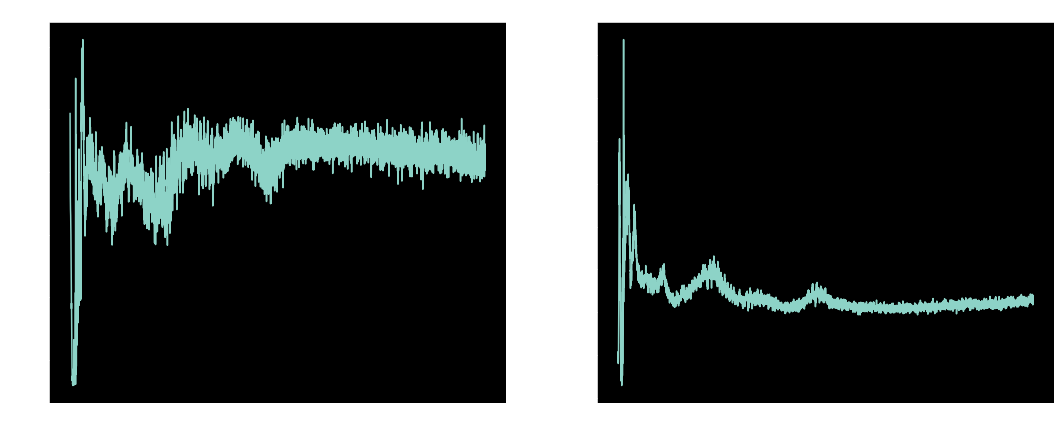

In [15]:
# Try model

latent_dim = 100
batch_size = 256
epochs = 21
dataset = x_train_reshaped

train(

    epochs=epochs, 
    generator=generator, 
    discriminator=discriminator, 
    gan=gan, 
    dataset=dataset, 
    latent_dim=latent_dim, 
    batch_size=batch_size

)

2022-06-08 13:22:52.018337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


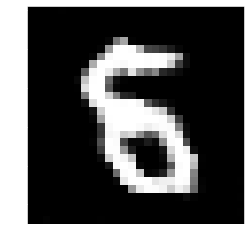

In [16]:
# Load model and generate image

model = load_model("mnist_gan_50_epochs.h5")

noise = np.random.normal(0, 1, (1, 100))
img = model.predict(noise, verbose=0)

plt.imshow(img.reshape((28, 28)), cmap="gray")
plt.show()